In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import gc

from tqdm import tqdm

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

import keras

plt.style.use('ggplot')

In [26]:
# !pip install --upgrade --force-reinstall --no-deps kaggle
# !mkdir /root/.kaggle

# with open("/root/.kaggle/kaggle.json", "w+") as f:
#     f.write('{"username":"","key":""}')
#     # Put your kaggle username & key here

# !chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d sharatsachin/criteo-attribution-modeling

Dataset URL: https://www.kaggle.com/datasets/sharatsachin/criteo-attribution-modeling
License(s): unknown
 99% 633M/641M [00:05<00:00, 87.3MB/s]
100% 641M/641M [00:05<00:00, 113MB/s] 


In [5]:
!unzip -q criteo-attribution-modeling -d ./data

In [6]:
!unzip -q criteo-attribution-modeling

In [7]:
df = pd.read_csv('pcb_dataset_final.tsv', sep='\t', nrows=2_000_000)

In [8]:
df.shape


(2000000, 22)

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   timestamp              int64  
 1   uid                    int64  
 2   campaign               int64  
 3   conversion             int64  
 4   conversion_timestamp   int64  
 5   conversion_id          int64  
 6   attribution            int64  
 7   click                  int64  
 8   click_pos              int64  
 9   click_nb               int64  
 10  cost                   float64
 11  cpo                    float64
 12  time_since_last_click  int64  
 13  cat1                   int64  
 14  cat2                   int64  
 15  cat3                   int64  
 16  cat4                   int64  
 17  cat5                   int64  
 18  cat6                   int64  
 19  cat7                   int64  
 20  cat8                   int64  
 21  cat9                   int64  
dtypes: float64(2), int

In [11]:
def add_jid(df):
    df['jid'] = df['uid'].map(str) + '_' + df['conversion_id'].map(str)
    return df

df = add_jid(df)

In [12]:
def normalize_time_cols(df):
    min_max_scaler = MinMaxScaler()
    for col in ('timestamp', 'time_since_last_click'):
        col_values = df[col].to_numpy().reshape(-1, 1)
        df[col + '_norm'] = min_max_scaler.fit_transform(col_values)
    return df

df = normalize_time_cols(df)

In [13]:
n_campaigns = len(df['campaign'].unique())

def sample_campaigns(df, n_campaigns):
    campaigns = np.random.choice(df['campaign'].unique(), n_campaigns, replace=False)
    return df[ df['campaign'].isin(campaigns) ]

df = sample_campaigns(df, n_campaigns)

In [14]:
def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name='count')
        return df[ df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].to_numpy() ) ]

df = filter_journeys_by_length(df, min_touchpoints=2)

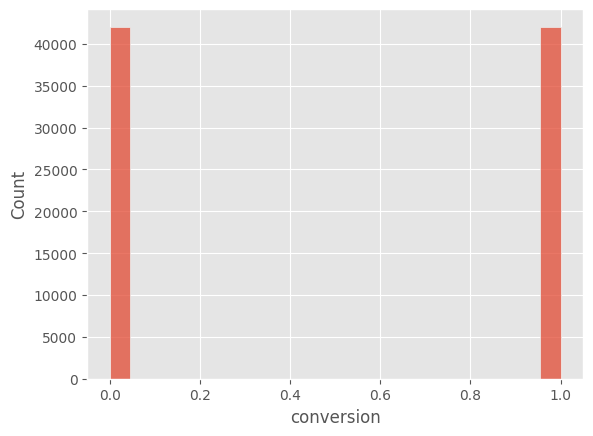

In [15]:
## balance the convert and no convert
def balance_conversions(df):
    df_converted = df[df['conversion'] == 1]
    df_not_converted = df[df['conversion'] == 0]

    number_of_splits = 100 * df_not_converted.shape[0] / df_converted.shape[0]
    df_not_converted_jids = np.array_split(df_not_converted['jid'].unique(), number_of_splits)

    df_not_converted_sampled = df_not_converted.iloc[0:0]
    for jid_chunk in df_not_converted_jids:
        df_not_converted_chunk = df_not_converted[df_not_converted['jid'].isin(jid_chunk)]
        df_not_converted_sampled = pd.concat([df_not_converted_sampled, df_not_converted_chunk])
        if df_not_converted_sampled.shape[0] > df_converted.shape[0]:
            break

    return pd.concat([df_not_converted_sampled, df_converted]).reset_index(drop=True)

df = balance_conversions(df)
sns.histplot(df["conversion"])
plt.show()

In [16]:
len(df['campaign'].unique())


647

In [17]:
df.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm
0,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,14584482,29196072,11409686,1973606,22644417,9312274,21091111,24607497_-1,0.000006,0.163527
1,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,10769841,29196072,5824237,138937,1795451,29196072,15351056,28474333_-1,0.000006,0.003426
2,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,31616034,29196072,11409684,26597096,4480345,29196072,29196072,25357769_-1,0.000009,0.000000
3,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,9107790,29196072,32440044,1973606,2687461,29841067,21091108,93907_-1,0.000012,0.101299
4,7,5588915,27491436,0,-1,-1,0,0,-1,-1,...,4281154,29196072,28928366,29196072,21857352,29196072,29196072,5588915_-1,0.000022,0.000000


In [18]:
def one_hot_encoder(df, column_names, result_column_name):
    one_hot_indices = {}
    for idx, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            one_hot_indices[str(val) + str(idx)] = len(one_hot_indices)

    def one_hot(values):
        one_hot_rep = np.zeros(len(one_hot_indices))
        for idx, val in enumerate(values):
            one_hot_rep[one_hot_indices[str(val) + str(idx)]] = 1
        return one_hot_rep

    df[result_column_name] = df[column_names].to_numpy().tolist()
    df[result_column_name] = df[result_column_name].map(one_hot)

    return df

df = one_hot_encoder(df, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df = one_hot_encoder(df, ['campaign'], 'campaigns').sort_values(by=['timestamp'])

In [19]:
feature_columns = ['jid', 'click', 'cost', 'time_since_last_click_norm', 'timestamp_norm', 'cats', 'campaigns', 'conversion']
df = df[feature_columns]

In [20]:
df

,jid,click,cost,time_since_last_click_norm,timestamp_norm,cats,campaigns,conversion
0,24607497_-1,0,0.000010,0.163527,0.000006,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,28474333_-1,0,0.000183,0.003426,0.000006,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,25357769_-1,0,0.000032,0.000000,0.000009,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,93907_-1,1,0.000186,0.101299,0.000012,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,5588915_-1,0,0.000074,0.000000,0.000022,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...,...
84013,4974276_8867151,1,0.000181,0.030606,0.999978,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
84014,6547472_4874491,1,0.001233,0.000171,0.999982,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
84015,11310999_9948445,1,0.001810,0.000026,0.999985,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
29836,12663914_-1,1,0.000054,0.000000,0.999991,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [21]:
gc.collect()


4996

In [22]:
def last_touch_attribution(df):
    # Define a function named last_touch_attribution that takes a DataFrame df as an argument.

    def count_by_campaign(df):
        # Define an inner function count_by_campaign that takes a DataFrame df as an argument.
        counters = np.zeros(n_campaigns)
        # Initialize an array of zeros, counters, with a length of n_campaigns to store the count for each campaign.
        for campaign_one_hot in df['campaigns'].to_numpy():
            # Iterate through the one-hot encoded campaign vectors in the DataFrame df.
            campaign_id = np.argmax(campaign_one_hot)
            # Find the position of the value 1 in the one-hot encoded vector, which corresponds to the campaign ID.
            counters[campaign_id] += 1
            # Increment the count for the corresponding campaign.
        return counters
        # Return the array of campaign counts.

    df_converted = df[df['conversion'] == 1]
    # Filter the DataFrame to include only rows where conversion is 1, storing the result in df_converted.

    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    # Create a boolean index idx by grouping df_converted by 'jid' and finding the rows with the maximum 'timestamp_norm' for each group.

    campaign_impressions = count_by_campaign(df)
    # Call the count_by_campaign function to count the number of impressions for each campaign and store the result in campaign_impressions.

    campaign_conversions = count_by_campaign(df_converted[idx])
    # Call the count_by_campaign function to count the number of conversions for each campaign, only considering the last touchpoint, and store the result in campaign_conversions.

    conversion_ratio = campaign_conversions / (campaign_impressions + 1)
    # Calculate the conversion ratio for each campaign (conversions / (impressions + 1)) and store the result in conversion_ratio. Adding 1 to avoid division by zero.

    conversion_ratio /= conversion_ratio.sum()
    # Normalize the conversion ratios so that their sum equals 1.

    return conversion_ratio
    # Return the normalized conversion ratios for each campaign.

lta = last_touch_attribution(df)
# Call the last_touch_attribution function to calculate the normalized conversion ratios for each campaign and assign the result to lta.

gc.collect()
# Call the garbage collector to free up unused memory.


0

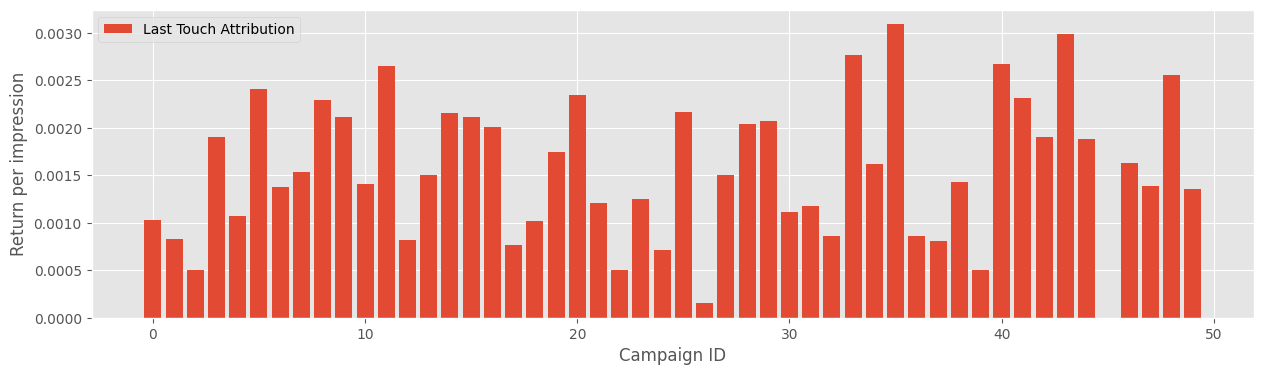

In [23]:
campaign_idx = range(150,200)

x = range(len(lta[campaign_idx]))
y = lta[campaign_idx]

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(x, y, label='Last Touch Attribution')
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [24]:
df = df.sort_values(by='jid')
gc.collect()

15

In [25]:
df

,jid,click,cost,time_since_last_click_norm,timestamp_norm,cats,campaigns,conversion
10015,10000148_-1,0,0.000188,0.084952,0.029158,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
10190,10000148_-1,0,0.000010,0.104075,0.181861,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
78897,10001378_24057324,1,0.014663,0.000060,0.896288,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
78864,10001378_24057324,1,0.002365,0.285709,0.895440,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
78874,10001378_24057324,1,0.006895,0.000047,0.895810,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...,...,...,...,...,...,...
52380,9994185_20428302,1,0.000010,0.112783,0.221119,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",1
15936,999441_-1,0,0.000010,0.109644,0.920880,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
15586,999441_-1,1,0.000031,0.000000,0.044657,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
25143,999663_-1,0,0.000265,0.246490,0.056854,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


This code defines a function called features for lstm that converts the data frame df into a three-dimensional feature matrix and corresponding labels that fit the LSTM (Long short-term memory) model


